# **[作業]電商如何以A/B Test 驗證新網頁設計有效**
## **Can eCommerce UX change boost the conversion rate from 0.13 to 0.15?**
知識點:

*   effect size
*   sample size for A/B test 
*   type I error = 0.05 and Power= 0.8
*   z-score, confidence interval

參考：A/B testing: A step-by-step guide in Python by Renato Fillinich @ medium.com

數據 : ab_data.csv from Kaggle

# **[作業目標]**

1.   了解Binomial分布，以及用常態分布求統計解的方法
2.   判讀A/B Test 結果



# **[作業重點]**



1.   如何決定最小樣本數
2.   如何以Z值，p-Value和信賴區間(Confidence Interval)判斷A/B結果是否顯著



In [1]:
# Packages imports
# 
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

%matplotlib inline

# Some plot styling preferences
plt.style.use('seaborn-whitegrid')
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}

mpl.rc('font', **font)

### 1.求樣本大小

In [5]:
# https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportion_effectsize.html

effect_size = sms.proportion_effectsize(0.13, 0.15)    # Calculating effect size based on our expected rates
print(effect_size,'\n')

# https://www.statsmodels.org/dev/generated/statsmodels.stats.power.NormalIndPower.solve_power.html
required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8,   #檢定力
    alpha=0.05,  #信心水準
    ratio=1)     # Calculating sample size needed

required_n = ceil(required_n)   # Rounding up to next whole number                          

print(required_n)

-0.0576728617308947 

4720


### 2.讀取資料

In [6]:
df = pd.read_csv('./ab_data.csv')

df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [8]:
df.info()

pd.crosstab(df['group'], df['landing_page'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


### 3.處理重複資料

In [11]:
#偵測重複出現使用者
session_counts = df['user_id'].value_counts(ascending=False)
session_counts

637561    2
821876    2
643869    2
938802    2
916765    2
         ..
710897    1
708848    1
665839    1
663790    1
630836    1
Name: user_id, Length: 290584, dtype: int64

In [12]:
#偵測重複出現使用者，即出現2次(含)以上

multi_users = session_counts[session_counts > 1].count()
print(f'There are {multi_users} users that appear multiple times in the dataset')

There are 3894 users that appear multiple times in the dataset


In [20]:
#除去重複出現使用者

#找出重複項目的index
users_to_drop = session_counts[session_counts > 1].index
users_to_drop

Int64Index([637561, 821876, 643869, 938802, 916765, 690255, 737500, 680018,
            853835, 736746,
            ...
            774079, 859519, 670799, 766516, 694299, 764658, 692496, 711355,
            813603, 701024],
           dtype='int64', length=3894)

In [16]:
print(df['user_id'].isin(users_to_drop))

0         False
1         False
2         False
3         False
4         False
          ...  
294473    False
294474    False
294475    False
294476    False
294477    False
Name: user_id, Length: 294478, dtype: bool


In [17]:
df[df['user_id'].isin(users_to_drop)]  #共有7788筆資料需要移除

,user_id,timestamp,group,landing_page,converted
22,767017,2017-01-12 22:58:14.991443,control,new_page,0
192,656468,2017-01-18 07:13:29.805052,treatment,new_page,1
226,773693,2017-01-23 18:05:45.167335,control,old_page,1
240,733976,2017-01-11 15:11:16.407599,control,new_page,0
246,704650,2017-01-04 19:10:52.655062,treatment,new_page,0
...,...,...,...,...,...
294308,905197,2017-01-03 06:56:47.488231,treatment,new_page,0
294309,787083,2017-01-17 00:15:20.950723,control,old_page,0
294328,641570,2017-01-09 21:59:27.695711,control,old_page,0
294331,689637,2017-01-13 11:34:28.339532,control,new_page,0


In [21]:
294478-7788 

286690

In [22]:
df = df[~df['user_id'].isin(users_to_drop)] #去除掉'user_id'欄位中，index在user_to_drop中的資料
print(f'The updated dataset now has {df.shape[0]} entries')

The updated dataset now has 286690 entries


In [25]:
df.info()
print('\n', required_n)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 286690 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       286690 non-null  int64 
 1   timestamp     286690 non-null  object
 2   group         286690 non-null  object
 3   landing_page  286690 non-null  object
 4   converted     286690 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.1+ MB

 4720


#### 4.控制組和實驗組各半 4720 * 2 = 9440

In [26]:
control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=22)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=22)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test

,user_id,timestamp,group,landing_page,converted
0,763854,2017-01-21 03:43:17.188315,control,old_page,0
1,690555,2017-01-18 06:38:13.079449,control,old_page,0
2,861520,2017-01-06 21:13:40.044766,control,old_page,0
3,630778,2017-01-05 16:42:36.995204,control,old_page,0
4,656634,2017-01-04 15:31:21.676130,control,old_page,0
...,...,...,...,...,...
9435,908512,2017-01-14 22:02:29.922674,treatment,new_page,0
9436,873211,2017-01-05 00:57:16.167151,treatment,new_page,0
9437,631276,2017-01-20 18:56:58.167809,treatment,new_page,0
9438,662301,2017-01-03 08:10:57.768806,treatment,new_page,0


In [27]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       9440 non-null   int64 
 1   timestamp     9440 non-null   object
 2   group         9440 non-null   object
 3   landing_page  9440 non-null   object
 4   converted     9440 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 368.9+ KB


#### 5.計算conversion rate 平均值，標準差，標準誤

In [28]:
#確認 ab_test 控制組實驗組各半
ab_test['group'].value_counts()

treatment    4720
control      4720
Name: group, dtype: int64

In [29]:
#計算各組的平均轉換率
conversion_rates = ab_test.groupby('group')['converted'].mean()
conversion_rates

group
control      0.123305
treatment    0.125636
Name: converted, dtype: float64

In [30]:
#計算各組的轉換率標準差
conversion_rates = ab_test.groupby('group')['converted'].agg( lambda x: np.std(x, ddof=0))
conversion_rates

group
control      0.328787
treatment    0.331438
Name: converted, dtype: float64

In [31]:
#計算各組的轉換率標準誤
conversion_rates = ab_test.groupby('group')['converted'].agg(lambda x: stats.sem(x, ddof=0))
conversion_rates

group
control      0.004786
treatment    0.004824
Name: converted, dtype: float64

In [32]:
#計算conversion rate 平均值，標準差，標準誤
conversion_rates = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

#conversion_rates
conversion_rates.style.format('{:.3f}') #四捨五入至小數點後三位

,conversion_rate,std_deviation,std_error
group,,,
control,0.123,0.329,0.005
treatment,0.126,0.331,0.005


#### 6.繪出 conversion rate 棒狀圖

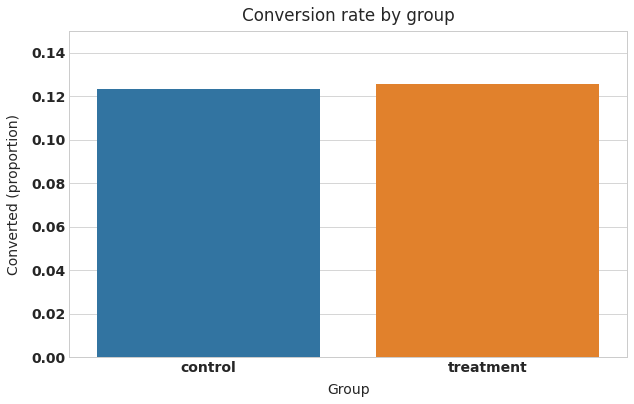

In [43]:
plt.figure(figsize=(10,6))

sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=True)

plt.ylim(0, 0.15)
plt.title('Conversion rate by group', pad=10)
plt.xlabel('Group', labelpad=8)
plt.ylabel('Converted (proportion)', labelpad=10);

#### 7.以函數計算z_stat, pval, confidence interval

In [44]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

#print(control_results)
#print(treatment_results)

In [46]:
n_con = control_results.count()
n_treat = treatment_results.count()

successes = [control_results.sum(), treatment_results.sum()]
# control_results.sum():控制組中轉換率為1的數量
# treatment_results.sum():對照組中轉換率為1的數量

nobs = [n_con, n_treat]

print(successes)
print(nobs)

[582, 593]
[4720, 4720]


In [47]:
#計算Z分數、p-value
# https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html

z_stat, pval = proportions_ztest(successes, nobs=nobs) 

(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05) #計算95%信賴區間的上下界

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')
#判讀統計結果

z statistic: -0.34
p-value: 0.732
ci 95% for control group: [0.114, 0.133]
ci 95% for treatment group: [0.116, 0.135]


# 作業：判讀程式最後統計結果，A/B test 是否顯著

z statistic: -0.34

p-value: 0.732

ci 95% for control group: [0.114, 0.133]

ci 95% for treatment group: [0.116, 0.135]

#### p-value 0.732 > 0.05, 統計上不顯著

# 作業：試以(0.12, 0.11)計算結果是否顯著


In [49]:
#求樣本大小

effect_size = sms.proportion_effectsize(0.12, 0.11)    

required_n2 = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8,   #檢定力
    alpha=0.05, 
    ratio=1
    )                                                  

required_n2 = ceil(required_n2)                                               
print(required_n2)

15970


In [50]:
#選取 控制組和實驗組各半 15970 * 2 = 31940
control_sample = df[df['group'] == 'control'].sample(n=required_n2, random_state=22)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n2, random_state=22)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)
#ab_test

In [51]:
#計算conversion rate 平均值，標準差，標準誤
conversion_rates = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

#conversion_rates
conversion_rates.style.format('{:.3f}') #四捨五入至小數點後三位

,conversion_rate,std_deviation,std_error
group,,,
control,0.121,0.326,0.003
treatment,0.121,0.326,0.003


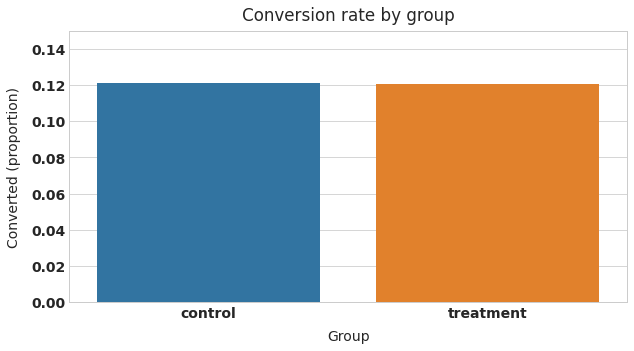

In [52]:
#繪出 conversion rate 棒狀圖
plt.figure(figsize=(10,5))

sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)

plt.ylim(0, 0.15)
plt.title('Conversion rate by group', pad=10)
plt.xlabel('Group', labelpad=10)
plt.ylabel('Converted (proportion)', labelpad=10);

In [53]:
#以函數計算z_stat, pval, confidence interval

from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()

successes = [control_results.sum(), treatment_results.sum()]
# control_results.sum():控制組中轉換率為1的數量
# treatment_results.sum():對照組中轉換率為1的數量

nobs = [n_con, n_treat]

print(successes)
print(nobs)

[1932, 1928]
[15970, 15970]


In [54]:
z_stat, pval = proportions_ztest(successes, nobs=nobs) #計算Z分數、p-value

(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05) #計算95%信賴區間的上下界

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')
#判讀統計結果

z statistic: 0.07
p-value: 0.945
ci 95% for control group: [0.116, 0.126]
ci 95% for treatment group: [0.116, 0.126]


#### p-value高於門檻值0.05，表示錯誤地拒絕虛無假設(虛無假設為真的清況下)的機率較高(比最低容忍程度還高)，傾向不拒絕虛無假設，意即控制組和對照組之間的轉換率沒有顯著的差別

# 作業：樣本數是以那些模組/函數算的

In [55]:
# https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportion_effectsize.html
effect_size = sms.proportion_effectsize(0.12, 0.11)    # Calculating effect size based on our expected rates


# https://www.statsmodels.org/dev/generated/statsmodels.stats.power.NormalIndPower.solve_power.html
required_n2 = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8,   #檢定力
    alpha=0.05, 
    ratio=1) # Calculating sample size needed